# NEON

This notebook is an excercise in executing ISOFIT on two dates from the NEON dataset and interpreting the outputs of ISOFIT. 

Prerequisites:
- Download sample data from https://avng.jpl.nasa.gov/pub/PBrodrick/isofit/tutorials/subset_data.zip.  This dataset was prepped already from the data_prep notebook.  Place the dataset into the NEON folder in this repo and unzip it, which will create the 'data' folder which includes the 'subsets' directory.
- Have a working installation of ISOFIT, with sRTMnet installed and configured (see environment variable specification on the next line)

In [43]:
# Jupyter magics
import matplotlib.pyplot as plt

# Setup logging
import logging
import os

from types import SimpleNamespace
import scipy

import isofit
from isofit.utils.apply_oe import apply_oe 
from isofit.utils.surface_model import surface_model

# Enable the ISOFIT logger
logging.getLogger().setLevel(logging.INFO)

# Find where we're running the tutorial from
home = os.path.abspath(os.getcwd())

# Path to the input NEON data
indata = os.path.join(home, 'data') 
subset_dir = os.path.join(indata, 'subsets')
print(f'Data subset directory at: {subset_dir}')

# Path to write isofit output
output = os.path.join(home,'outputs')
if os.path.isdir(output) is False:
    os.mkdir(output)

if os.path.isdir(subset_dir) is False:
    os.mkdir(subset_dir)

surface_model_path = os.path.join(isofit.root, 'examples/20171108_Pasadena/configs/ang20171108t184227_surface.json')
print(f'Surface model at: {surface_model_path}')
neon_id = '173647'


# Optionally set some environment variables as needed
#os.environ['EMULATOR_PATH'] = '/Users/brodrick/isofit_support/sRTMnet_v120.h5'
#os.environ['SIXS_DIR'] = '/Users/brodrick/6s/'

print(f'sRTMnet emulator path (required): {os.environ["EMULATOR_PATH"]}')
print(f'6s path (required): {os.environ["SIXS_DIR"]}')




%matplotlib inline

Data subset directory at: /Users/brodrick/repos/isofit-tutorials/isotuts/NEON/data/subsets
Surface model at: /Users/brodrick/repos/isofit/examples/20171108_Pasadena/configs/ang20171108t184227_surface.json
sRTMnet emulator path (required): /Users/brodrick/isofit_support/sRTMnet_v120.h5
6s path (required): /Users/brodrick/6s/


## Setup

ISOFIT needs at minimum three pieces as input:

    1. Radiance measurements (rdn)
    2. Observation values    (obs)
    3. Location information  (loc)

This sample dataset from NEON has radiance and observation data, but no location values (more recent NEON datasets include the location file).  However, we can 'fake' the location file with sufficient accuracy for ISOFIT to run successfully.  Note that there are data available for two dates:

```
Radiance
├── 173647
│   ├── NIS01_20210403_173647_obs_ort
│   ├── NIS01_20210403_173647_obs_ort.hdr
│   ├── NIS01_20210403_173647_rdn_ort
│   └── NIS01_20210403_173647_rdn_ort.hdr
└── 174150
    ├── NIS01_20210403_174150_obs_ort
    ├── NIS01_20210403_174150_obs_ort.hdr
    ├── NIS01_20210403_174150_rdn_ort
    └── NIS01_20210403_174150_rdn_ort.hdr
```

These files have corresponding in situ data as well, and below we've encoded the locations of each, which we can use to help subset data files.


In [19]:
import numpy as np

# Extract the image locations of each point of interest (POI)
# These are defined in the NEON report as pixel locations, so we round here to convert to indices
report = {}
report['173647'] = {           # Upp L Y  | Low R Y  | Upp L X | Low R X
    'WhiteTarp': np.round([2224.9626, 2230.9771, 316.0078, 324.9385,]).astype(int),
    'BlackTarp': np.round([2224.9626, 2231.0032, 328.0086, 333.9731,]).astype(int),
    'Veg'      : np.round([2245.0381, 2258.8103, 343.9006, 346.9423,]).astype(int),
    'RoadEW'   : np.round([2214.9905, 2216.9978, 348.9902, 373.0080,]).astype(int),
    'RoadNS'   : np.round([2205.9580, 2225.9612, 357.9536, 359.9608,]).astype(int)
}
report['174150'] = {           # Upp L Y | Low R Y | Upp L X  | Low R X
    'WhiteTarp': np.round([653.9626, 659.9771, 3143.0078, 3151.9385]).astype(int),
    'BlackTarp': np.round([653.9626, 660.0032, 3155.0086, 3160.9731]).astype(int),
    'Veg'      : np.round([674.0381, 687.8103, 3170.9006, 3173.9423]).astype(int),
    'RoadEW'   : np.round([643.9905, 645.9978, 3175.9902, 3200.0080]).astype(int),
    'RoadNS'   : np.round([634.9580, 654.9612, 3184.9536, 3186.9608]).astype(int)
}
# Converts numpy array to comma-separated string for ISOFIT
toString = lambda array: ', '.join(str(v) for v in array)

In [4]:
# Which NEON date to process - change this to process a different date
neon_id = list(report.keys())[0]

# Select the locations from the neon id -- roi == Regions of Interest
roi = report[neon_id]



## Loc file generation

NEON doesn't distribute (?) a loc file, so let's fake one for now.  We'll do this for the full file and for the subset.

In [5]:
from isotuts.utils import fakeLOC

fakeLOC(
    rdn = os.path.join(indata,f'NIS01_20210403_{neon_id}_rdn_ort.hdr'),
    lon = -105.237000,
    lat = 40.125000,
    elv = 1689.0
)


fakeLOC(
    rdn = os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_rdn_ort.hdr'),
    lon = -105.237000,
    lat = 40.125000,
    elv = 1689.0
)

Key 'band names' not found in the metadata, skipping


Key 'band names' not found in the metadata, skipping


# Apply OE

The next part walks through running the ISOFIT utility script `isofit/utils/apply_oe.py`. This is the first step of executing ISOFIT and will generate a default configuration.

In [25]:
output_surface_file = os.path.join(output, 'surface.mat')
surface_model(**{
    'config_path': surface_model_path,
    'output_path': output_surface_file,
    'wavelength_path': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_rdn_ort.hdr')
}

)

0 ['../../../data/reflectance/surface_model_ucsb']
1 ['../../../data/reflectance/surface_model_ucsb']
2 ['../../../data/reflectance/surface_model_ucsb']
3 ['../../../data/reflectance/surface_model_ucsb']
4 ['../../../data/reflectance/surface_model_ucsb']
5 ['../../../data/reflectance/surface_model_ucsb']
6 ['../../../data/reflectance/surface_model_ucsb']
7 ['../../../data/reflectance/surface_model_ucsb']


In [39]:
# Add a ray shutdown, just in case this is being re-called
import ray
ray.shutdown()

args = SimpleNamespace(**{
        'input_radiance': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_rdn_ort'), # Radiance
        'input_loc': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_loc_ort'), # Location
        'input_obs': os.path.join(subset_dir,f'NIS01_20210403_{neon_id}_rdn_obs_ort'), # Observations
        'working_directory': os.path.join(output, f'NIS01_20210403_{neon_id}'), # Output directory
        'sensor': 'neon', 

        "surface_path": output_surface_file, # Surface priors - often changes

        'emulator_base': os.environ['EMULATOR_PATH'],
        "modtran_path": None,
        'n_cores': 4,
        "copy_input_files": False,
        "wavelength_path": None,
        "surface_category": "multicomponent_surface",
        "aerosol_climatology_path": None, # MODTRAN
        "atmosphere_type": "ATM_MIDLAT_SUMMER", # MODTRAN
        "rdn_factors_path": None, # RCC update used 'on the fly'
        "channelized_uncertainty_path": None, # Channelized uncertainty - if you have an instrument model
        "model_discrepancy_path": None, # Model discrepancy term - handle things like unknown radiative transfer model effects

        "lut_config_file": None,
        "multiple_restarts": False, # Useful if the AOD conditions are really challenging
        "logging_level": "INFO",
        "log_file": None,
        "num_cpus": 1,
        "memory_gb": -1,
        "presolve": True, # Attempts to solve for the right wv range

        "empirical_line": False, # wavelength-specific local linear interpolation between radiance and reflectance
        "analytical_line": True, # mathematical representation of OE given that the atmsophere is known

        "ray_temp_dir": "/tmp/ray",
        "segmentation_size": 10,
        "num_neighbors": [5],
        "atm_sigma": [0.5, 0.5],
        "pressure_elevation": False,
        "prebuilt_lut": None
    })

apply_oe(args)

2024-07-22 09:56:47,340	INFO worker.py:1724 -- Started a local Ray instance.
INFO:2024-07-22,09:56:47 || apply_oe.py:apply_oe() | namespace(input_radiance='/Users/brodrick/repos/isofit-tutorials/isotuts/NEON/data/subsets/NIS01_20210403_173647_rdn_ort', input_loc='/Users/brodrick/repos/isofit-tutorials/isotuts/NEON/data/subsets/NIS01_20210403_173647_loc_ort', input_obs='/Users/brodrick/repos/isofit-tutorials/isotuts/NEON/data/subsets/NIS01_20210403_173647_rdn_obs_ort', working_directory='/Users/brodrick/repos/isofit-tutorials/isotuts/NEON/outputs/NIS01_20210403_173647', sensor='neon', surface_path='/Users/brodrick/repos/isofit-tutorials/isotuts/NEON/outputs/surface.mat', emulator_base='/Users/brodrick/isofit_support/sRTMnet_v120.h5', modtran_path=None, n_cores=4, copy_input_files=False, wavelength_path=None, surface_category='multicomponent_surface', aerosol_climatology_path=None, atmosphere_type='ATM_MIDLAT_SUMMER', rdn_factors_path=None, channelized_uncertainty_path=None, model_discre

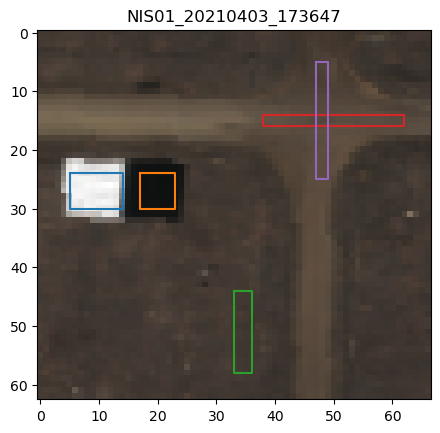

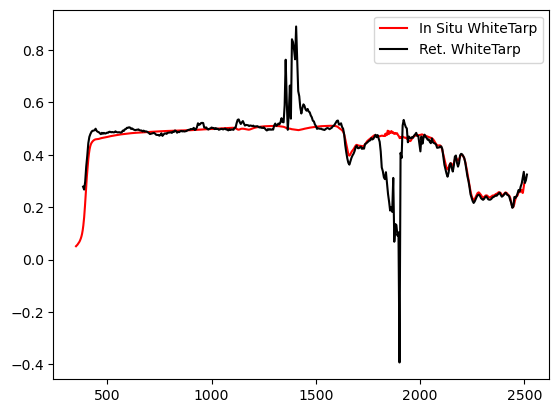

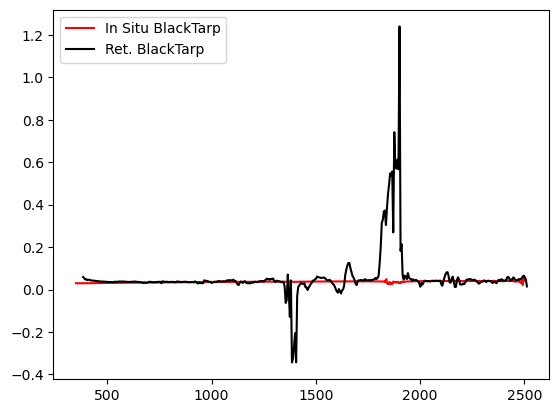

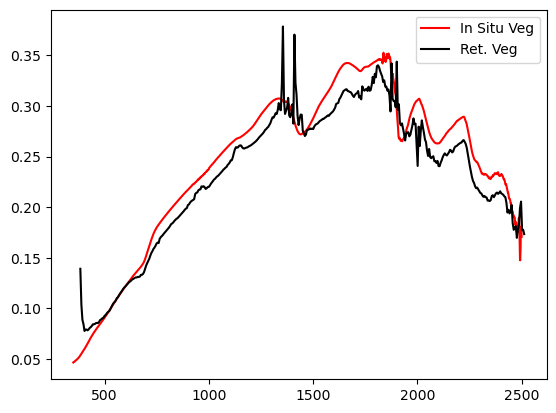

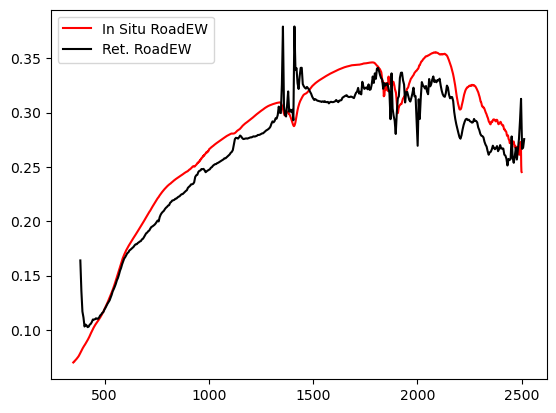

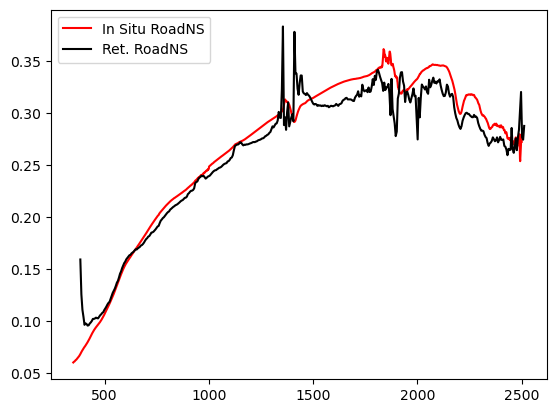

In [38]:
from spectral.io import envi
import matplotlib.pyplot as plt
for _key, key in enumerate(report.keys()):
  if _key < 1:

    rfl_ds = envi.open(os.path.join(output, f'NIS01_20210403_{key}','output',f'NIS01_20210403_{key}_rfl.hdr'))
    rfl_rgb = rfl_ds.open_memmap(interleave='bip')[:,:,np.array([60,40,30])].copy()
    wl = np.array([float(x) for x in rfl_ds.metadata['wavelength']])

    miny = np.min([np.min([i[0],i[1]]) for k,i in report[key].items()])-5
    maxy = np.max([np.max([i[0],i[1]]) for k,i in report[key].items()])+5
    minx = np.min([np.min([i[2],i[3]]) for k,i in report[key].items()])-5
    maxx = np.max([np.max([i[2],i[3]]) for k,i in report[key].items()])+5

    plt.figure()
    plt.imshow(rfl_rgb / np.max(rfl_rgb,axis=(0,1)))
    plt.title(f'NIS01_20210403_{key}')
    for k,i in report[key].items():
        plt.plot([i[2]-minx,i[3]-minx,i[3]-minx,i[2]-minx,i[2]-minx],[i[0]-miny,i[0]-miny,i[1]-miny,i[1]-miny,i[0]-miny],label=k)

    for k,i in report[key].items():
        plt.figure()
        in_situ = np.genfromtxt(f'data/FieldSpectrometer/{k}01/Data/{k}01_Refl.dat', skip_header=3)
        plt.plot(in_situ[:,0], in_situ[:,1], label=f'In Situ {k}',c='red',ls='-')
        mean_rfl = np.mean(rfl_ds.open_memmap(interleave='bip')[i[0]-miny:i[1]-miny,i[2]-minx:i[3]-minx,:],axis=(0,1))
        plt.plot(wl, mean_rfl, label=f'Ret. {k}', c='black')
        plt.legend()


We can also plot out the mapped reflectance (as above), but also the interpolated atmospheric conditions.  The windows size is small enough here (and the atmospheric parameters are chosen in such a way) that the map is going to be pretty static...but we can still see it.

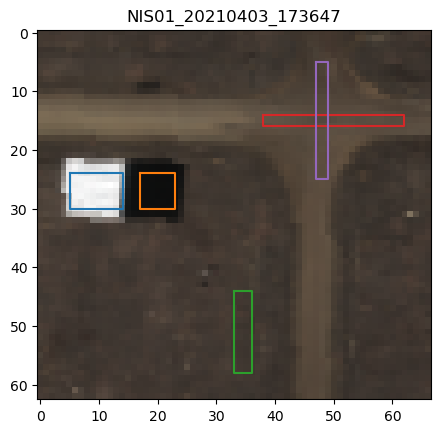

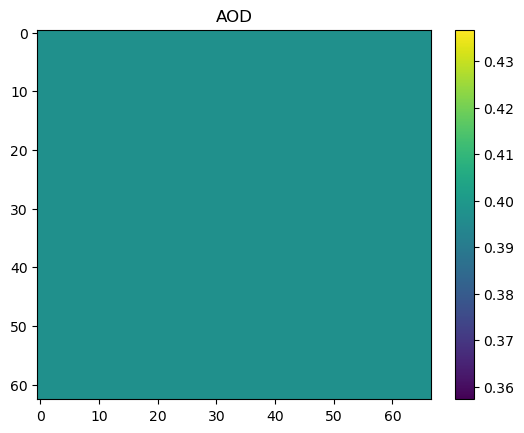

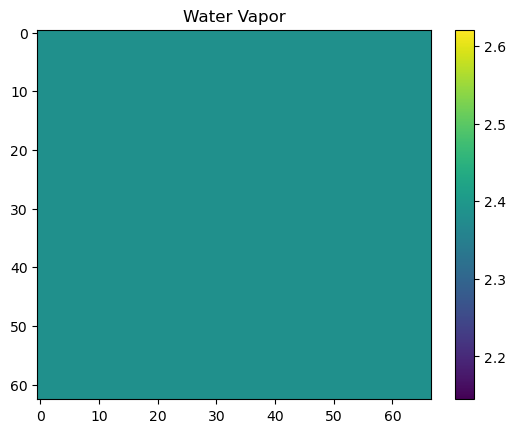

In [42]:
for _key, key in enumerate(report.keys()):
  if _key < 1:

    rfl_ds = envi.open(os.path.join(output, f'NIS01_20210403_{key}','output',f'NIS01_20210403_{key}_rfl.hdr'))
    rfl_rgb = rfl_ds.open_memmap(interleave='bip')[:,:,np.array([60,40,30])].copy()
    wl = np.array([float(x) for x in rfl_ds.metadata['wavelength']])

    miny = np.min([np.min([i[0],i[1]]) for k,i in report[key].items()])-5
    maxy = np.max([np.max([i[0],i[1]]) for k,i in report[key].items()])+5
    minx = np.min([np.min([i[2],i[3]]) for k,i in report[key].items()])-5
    maxx = np.max([np.max([i[2],i[3]]) for k,i in report[key].items()])+5

    plt.figure()
    plt.imshow(rfl_rgb / np.max(rfl_rgb,axis=(0,1)))
    plt.title(f'NIS01_20210403_{key}')
    for k,i in report[key].items():
        plt.plot([i[2]-minx,i[3]-minx,i[3]-minx,i[2]-minx,i[2]-minx],[i[0]-miny,i[0]-miny,i[1]-miny,i[1]-miny,i[0]-miny],label=k)

    plt.figure()
    atm_ds = envi.open(os.path.join(output, f'NIS01_20210403_{key}','output',f'NIS01_20210403_{key}_atm_interp.hdr'))
    atm = atm_ds.open_memmap(interleave='bip').copy()
    plt.imshow(atm[...,0])
    plt.title('AOD')
    plt.colorbar()

    plt.figure()
    plt.imshow(atm[...,1])
    plt.title('Water Vapor')
    plt.colorbar()

    plt.imshow